# Conversion rate significance AB experiment based on UI design of e-commerce 


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B testing, also known as split testing, is a method used to compare two versions of a webpage or app against each other to determine which one performs better. Essentially, it's an experiment where two or more variants of a page are shown to users at random, and statistical analysis is used to determine which variation performs better for a given conversion goal. A/B tests are very commonly performed by data analysts and data scientists.

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability



In [85]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy
from scipy import stats

%matplotlib inline
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  
a. Read in the dataset and take a look at the top few rows here:

In [86]:
df=pd.read_csv('ab_data.csv')

In [87]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [88]:
len(df)

294478

c. The number of unique users in the dataset.

In [89]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [90]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

`Treatment` group should use `new page`. While `control` group should use `old page`. 

In [91]:
df['landing_page'].value_counts()

old_page    147239
new_page    147239
Name: landing_page, dtype: int64

In [92]:
df_A_not_B = df.query('group == "treatment" & landing_page == "old_page"')

df_B_not_A = df.query('group == "control" & landing_page == "new_page"')

#calculate thenumber of time new_page and treatment don't line up
len(df_A_not_B) + len(df_B_not_A)

3893

f. Do any of the rows have missing values?

In [93]:
df.isnull().any(axis=1).sum()


0

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.


In [94]:
#remove the mismatch rows
df1 = df.drop(df[(df.group =="treatment") & (df.landing_page != "new_page")].index)

df2 = df1.drop(df1[(df.group =="control") & (df1.landing_page != "old_page")].index)

/var/folders/rq/rtxryn3j4c91cgyhb885lxn40000gn/T/ipykernel_21165/2520072454.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df1.drop(df1[(df.group =="control") & (df1.landing_page != "old_page")].index)


In [95]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** in the following investigation

a. How many unique **user_id**s are in **df2**?

In [96]:
df2['user_id'].nunique()

290584

In [97]:
# check if there is an duplicated user_id
df2['user_id'].duplicated().sum()


1

b. There is one **user_id** repeated in **df2**.  What is it?

In [98]:
#find out the duplicate user_id
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [99]:
df2.drop(labels=2893, inplace=True)

In [100]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


d. What is the probability of an individual converting regardless of the page they receive?

In [101]:
df2['converted'].mean()

0.11959708724499628

e. Given that an individual was in the `control` group, what is the probability they converted? What is the probability they convertd in the `treatment` group?

In [102]:
df2.groupby(['group'],as_index=False).mean()

/var/folders/rq/rtxryn3j4c91cgyhb885lxn40000gn/T/ipykernel_21165/2336911465.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2.groupby(['group'],as_index=False).mean()


,group,user_id,converted
0,control,788164.072594,0.120386
1,treatment,787845.719290,0.118808


f. What is the probability that an individual received the new page?

In [103]:
len(df2.query('landing_page == "new_page"'))/len(df2.landing_page)

0.5000619442226688

#### Findings:
This dataset includes two groups, old page (control) and new page (treatment), equally. The convert rate in this dataset is 11.96% regardless of pages. The convert rate in the old page is 12.04% than the convert rate in the new page, 11.88%. The differeence is only 0.15%, so it is very hard to tell which page leads to more conversions than another. We need to implement an experiment to see if the difference is statistically significant.

So, there is not sufficient evidence to say that the new treatment page leads to more conversions.

The test seems to be well designed. Half of the population received the old_page and half of the population received the new_page. The population is considerable in size (290584 users).


<a id='ab_test'></a>
### Part II - A/B Test

Notice the `timestamp` column in the dataset? Because of the time stamp associated with each event, the company could technically run the A/B test and hypothesis test infinitely as each observation can be observed over time. 

However, Company has to make a decision at the end. How long do you run the test to decide one page is better than another or neither page is better than another? The challenge part is that do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time? 

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider I need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. 

- <font color="red">Null hypothesis: the conversion rate of the old_page is greater or the same than the conversion rate of the new_page.</font>

$$p_{old} >= p_{new}$$

- <font color="blue">Alternative hypothesis: the conversion rate of the old_page is less than the conversion rate of the new_page.</font>


$$p_{old} < p_{new}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  

a. What is the **convert rate** for $p_{new}$ under the null?

In [104]:
#the Null hypothesis states there is no difference between the
#conversion rates of old and new page. Thus, the whole dataset is used to
#calculate the convertion rate for the new page (pnew).
p_new = df2['converted'].mean()
p_new


0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [105]:
p_old=p_new
p_old

0.11959708724499628

c. What is $n_{new}$?

In [106]:
n_new=len(df2.query('landing_page == "new_page"'))
n_new

145310

d. What is $n_{old}$?

In [107]:
n_old=len(df2.query('landing_page == "old_page"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [108]:
new_page_converted = np.random.binomial(1,p_new,n_new)
len(new_page_converted)


145310

In [109]:
new_page_converted.mean()

0.11986786869451517

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [110]:
old_page_converted = np.random.binomial(1,p_old,n_old)
len(old_page_converted)

145274

In [111]:
old_page_converted.mean()

0.11814226909150984

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [112]:
new_page_converted.mean() - old_page_converted.mean()

0.0017255996030053344

h. Simulate 10,000 ($p_{new}$ - $p_{old}$) values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [113]:
p_diffs=[]
for _ in range(10000):
    new_page_converted = np.random.binomial(1,p_new,n_new).mean()
    old_page_converted = np.random.binomial(1,p_old,n_old).mean()
    p_diffs.append(new_page_converted - old_page_converted)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

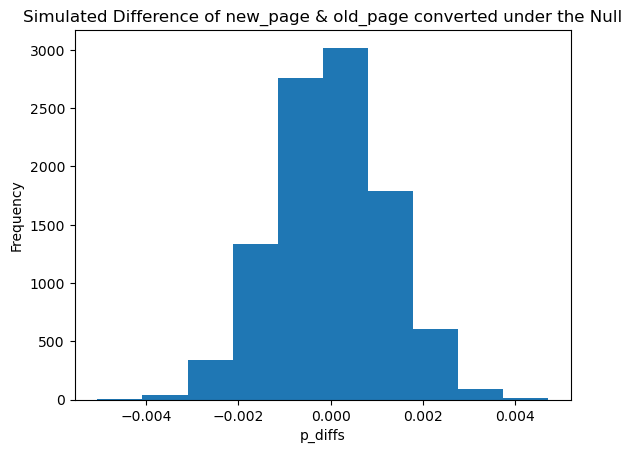

In [114]:
# Convert p_diffs to a numpy array (if it's not already one)
p_diffs = np.array(p_diffs)

# Plot the histogram of the sampling distribution
plt.hist(p_diffs)
plt.xlabel('p_diffs')  # Difference in conversion rates
plt.ylabel('Frequency')  # Frequency of each difference
plt.title('Simulated Difference of new_page & old_page converted under the Null')

# Display the plot
plt.show()

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [115]:
df_new = df2.query('landing_page == "new_page"')
df_old = df2.query('landing_page == "old_page"')

# display observed difference
obs_diff = df_new.converted.mean() - df_old.converted.mean()
obs_diff

-0.0015782389853555567

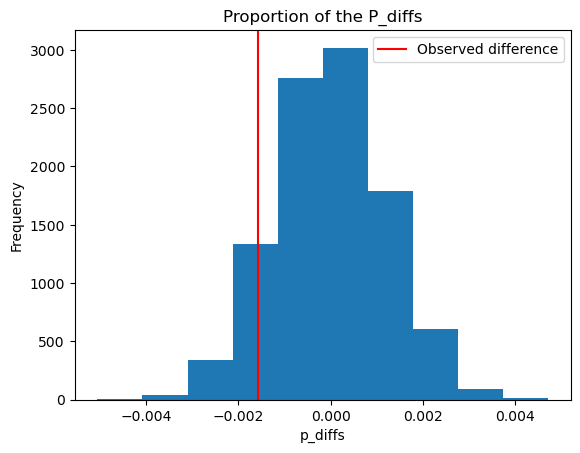

In [116]:
# plot line for observed statistic
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color='r', label="Observed difference")
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Proportion of the P_diffs');
plt.legend()
plt.show()

In [117]:
(p_diffs > obs_diff).mean()

0.9058

91% is the proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv. In scientific studies this value is also called p-value. This value means that we cannot reject the null hypothesis and that we do not have sufficient evidence that the new_page has a higher conversion rate than the old_page.

### Alternative Approach

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [118]:
import statsmodels.api as sm

n_new = len(df2.query('landing_page == "new_page"'))
n_old = len(df2.query('landing_page == "old_page"'))
converted_new = len(df2.query('landing_page == "new_page" & converted == 1'))
converted_old = len(df2.query('landing_page == "old_page" & converted == 1'))


In [119]:
n_new,n_old

(145310, 145274)

In [120]:
converted_new,converted_old

(17264, 17489)

In [121]:
z_score, p_value = sm.stats.proportions_ztest([converted_old, converted_new], [n_old, n_new],value=None, alternative='smaller', prop_var=False)
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

#### Conclusion
The z-score and p-value indicate that we should not reject the Null Hypothesis, which asserts that the conversion rate of the old_page is equal to or higher than that of the new_page. With a p-value of 0.91, greater than 0.05 threshold of significance, we are not confident with a 95% confidence level to say the converted rate of the new page is larger than the old page. 

<a id='regression'></a>
### Part III - A regression approach

`1.` Each row of our dataset is either converted or not converted based on the groups. The target variable is a binary variable (converted or not converted). Therefore, we can use logistic regression. 


I will use **statsmodels** to fit the regression model  see if there is a significant difference in conversion based on which page a customer receives. I will first need to create a dummy variable column for which group each user is in, and Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **new page** and 0 if **old page**.

In [122]:
df2[['control','treatment']]= pd.get_dummies(df2['group'])
df2 = df2.drop('control',axis = 1)

df2.head()

,user_id,timestamp,group,landing_page,converted,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0


In [123]:
df3 = df2.rename(columns={'treatment': 'ab_page'})
df3['Intercept']=1
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,Intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1



c. Use **statsmodels** to build  regression model,and fit the model using the two columns I created previously to predict whether or not an individual converts.

In [54]:
from scipy import stats

df3 = df3.dropna()
lm = sm.Logit(df3['converted'],df3[['Intercept','ab_page']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 29 Feb 2024   Pseudo R-squ.:               8.077e-06
Time:                        16:44:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [61]:

print(f"Intercept: {results.params['Intercept']}")
print(f"Coefficient for ab_page: {results.params['ab_page']}")


Intercept: -1.9887770522958599
Coefficient for ab_page: -0.0149891135482512


In [67]:
odds_ratio = np.exp(results.params['ab_page'])
odds_ratio

0.9851226640350357

### Findings

An odds ratio of 1 implies no change in the odds. This means that the presence of the independent variable does not affect the odds of the dependent variable.




The P-value is very different in A/B test and Regression model. In part II, the **p-value** is 0.905. However, in part III, the **p-value** is 0.19 because the tests of the regression model assumes an intercept and because of differences in one or two-tailed testing.

For the hypothesis tests in AB test and two sample proportion, we calculate the proportions in two groups and test that there is any difference of convert rates between new pages and old pages.We obtain p-value at 0.905 means that we cannot reject the null hypothesis, the convert rate in the old page is better than in the new page at a Type I error of 5%.

Alternative hypothesis from part II: the conversion rate of the old_page is less than the conversion rate of the new_page. This assumes a one-tailed test. In Part III, the alternative hypothesis can be formulated as follows:
(1) The landing_page type influences (positively or negatively) the conversion rate or (2) the conversion rate of the old_page is different to the conversion rate of the new_page. This assumes a two-tailed test.

Because of different calculations and circumstance, our p-values are different but we get the same conclusion.

It is a good idea to consider other factors in order to identify other potencial influences on the conversion rate.

A disadvantage is that the model gets more complex.

## Country effect

Now along with testing if the conversion rate changes for different pages, Does different country display a different conversion results from old page and new page?  I will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows. 



In [70]:
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [71]:
countries_df.shape

(290584, 2)

In [72]:

df_new = countries_df.set_index('user_id').join(df3.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,Intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [73]:
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [74]:
#mean of conversion rate
df_new.ab_page.mean()

0.5000619442226688

In [75]:
#mean conversion rate by country
df_new.groupby(['country'], as_index=True).mean()

/var/folders/rq/rtxryn3j4c91cgyhb885lxn40000gn/T/ipykernel_21165/2273498006.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_new.groupby(['country'], as_index=True).mean()


,converted,ab_page,Intercept
country,,,
CA,0.115318,0.503552,1.0
UK,0.120594,0.498247,1.0
US,0.119547,0.500459,1.0


In [76]:
#mean conversion rate by landing_page
df_new.groupby(['ab_page']).mean()

/var/folders/rq/rtxryn3j4c91cgyhb885lxn40000gn/T/ipykernel_21165/2565787446.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_new.groupby(['ab_page']).mean()


,converted,Intercept
ab_page,,
0,0.120386,1.0
1,0.118808,1.0


In [77]:
# Create the necessary dummy variables
df_new[['CA','UK', 'US']]= pd.get_dummies(df_new['country'])

df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,Intercept,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [78]:
### Fit  Linear Model And Obtain the Results

df_new['intercept'] = 1

lm = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','CA','US']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 29 Feb 2024   Pseudo R-squ.:               2.323e-05
Time:                        23:49:07   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
==============================================================================
"""

### Findings
The country does not appear to have influence on the convertion rate. P-values for the two dummy country variables are above 0.05. Note the P-value for CA variable are very close to 0.05

And now I have found out that individual factors of country and page on conversion, I would  like to look at an interaction between page and country to see if there significant effects on conversion.

In [79]:
df_new.groupby(['country','ab_page'], as_index=False).mean()

/var/folders/rq/rtxryn3j4c91cgyhb885lxn40000gn/T/ipykernel_21165/843889921.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_new.groupby(['country','ab_page'], as_index=False).mean()


,country,ab_page,converted,Intercept,CA,UK,US,intercept
0,CA,0,0.118783,1.0,1.0,0.0,0.0,1.0
1,CA,1,0.111902,1.0,1.0,0.0,0.0,1.0
2,UK,0,0.120022,1.0,0.0,1.0,0.0,1.0
3,UK,1,0.121171,1.0,0.0,1.0,0.0,1.0
4,US,0,0.120630,1.0,0.0,0.0,1.0,1.0
5,US,1,0.118466,1.0,0.0,0.0,1.0,1.0


By looking at an interaction, I will explore whether the influence of the landing_page might work in the US but not in the other countries, or Canada but not in other countries. Or the other way around.


In [80]:
df_new['interaction_us_ab_page'] = df_new.US *df_new.ab_page
df_new['interaction_ca_ab_page'] = df_new.CA *df_new.ab_page

df_new.head()


,country,timestamp,group,landing_page,converted,ab_page,Intercept,CA,UK,US,intercept,interaction_us_ab_page,interaction_ca_ab_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0,0


In [81]:
df_new['intercept'] = 1

lm = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','US','interaction_us_ab_page','CA','interaction_ca_ab_page']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 01 Mar 2024   Pseudo R-squ.:               3.482e-05
Time:                        23:24:02   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                 -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page                    0.0108      0.023      0.475      0.635      -0.034       0.056
US                         0.0057      0.019      0.306      0.760      -0.031       0.043
interaction_us_ab_page    -0.0314      0.027     -1.181      0.238      -0.084       0.021
CA                        -0.0118      0.040     -0.296      0.767      -0.090       0.066
interaction_ca_ab_page    -0.0783      0.057     -1.378      0.168      -0.190       0.033
==========================================================================================
"""

In [84]:
print(f"Intercept: {results.params['intercept']}")
print(f"Coefficient for ab_page: {results.params['ab_page']}")
print(f"Coefficient for US: {results.params['US']}")
print(f"Coefficient for interaction_us_ab_page: {results.params['interaction_us_ab_page']}")
print(f"Coefficient for CA: {results.params['CA']}")
print(f"Coefficient for interaction_ca_ab_page: {results.params['interaction_ca_ab_page']}")

Intercept: -1.9922218270157483
Coefficient for ab_page: 0.010834225811296104
Coefficient for US: 0.005743994503104942
Coefficient for interaction_us_ab_page: -0.03139779915074521
Coefficient for CA: -0.011783825681389085
Coefficient for interaction_ca_ab_page: -0.07828236110972323


### Summary and conclusion on regression

The p_value for all of the coefficient terms is higher than 0.05.

Thus, the influence of landing_page in the US is not different to the influence of landing_page in the other countries.

And the influence of landing_page in Canada is not different to the influence of landing_page in the other countries.

<a id='conclusions'></a>
## Conclusions

To conclude, the available data does not provide sufficient evidence to support the assertion that the new_page leads to higher conversion rates than the old_page. This conclusion is drawn from analyses involving probability figures, A/B testing, and regression models. Additionally, the data does not present compelling evidence to suggest that the conversion rate is significantly affected by the countries (US, CA, and UK).

Since the sample size of the data is large enough, continuing the testing of the new_page is likely not necessary. It is best to focus on the development of another new landing page. 

